Summary:

Main experimentation notebook. Code modularized to select a dataloader and vectorizer, and then to test various models with cross validation. Additional results / statistics generated once a classifier is selected on.

In [1]:
from DataLoaders import AbstractDataLoader, OriginalDataLoader, StemDataLoader, NoSWLoader, GPTCleanedLoader, MatchLoader
from Vectorizers import AbstractVectorizer, BOWVectorizer, W2VVectorizer, PreW2V, FastTextVectorizer, AdaVectorizer
from type_utils import ProcessedData, MatchedData, UnprocessedData
from sklearn.model_selection import train_test_split
from typing import List
import numpy as np

Load and vectorize data:

In [3]:
np.random.seed(17)

dataloaders: List[AbstractDataLoader] = [
    OriginalDataLoader(data_path='../william_data/test_xml/'),
    StemDataLoader(data_path='../william_data/test_xml/'),
    NoSWLoader(data_path='../william_data/test_xml/'), # loader without stopwords
    GPTCleanedLoader(data_path='../william_data/test_xml/', cleaned_path='../william_data/cleanedjson/'),
    MatchLoader(data_path='../william_data/test_xml/')
]

dataloader = dataloaders[3] # GPT
data: ProcessedData = dataloader.load_and_preprocess_data()

  3%|▎         | 1/37 [00:00<00:05,  6.62it/s]

loading from json
loading from json


  5%|▌         | 2/37 [00:00<00:13,  2.66it/s]

loading from json


  8%|▊         | 3/37 [00:01<00:17,  1.93it/s]

incoming msg [{'role': 'system', 'content': "Votre travail consiste à transformer cette numérisation OCR défectueuse en une numérisation rectifiée, en corrigeant l'espacement, le formatage et la grammaire et la syntaxe appropriées en français si nécessaire. Renvoie uniquement le texte corrigé, sans nouvelle ligne supplémentaire ni espace blanc divers. N'ajoutez PAS de contenu supplémentaire à votre réponse, sinon vous serez pénalisé."}, {'role': 'user', 'content': "st ici en même temps excès de faiblesse. — 42 — Ces quelques lignes que nous venons d'écrire, c’est l’histoire politique de Paris capitale. En l’état de nos institutions et de nos habitudes, les individualités actives ou brouillonnes que sollicite l'appétit du pouvoir ou le désir de se produire, ne trouvant point, dans la vie politique dela province, un aliment qui ieur suffise, se ruent de toutes parts vers Paris. Là, elles se bousculent et s'étouffent sous l’âpre aiguillon d'une concurrence effrénée. Accueillies, mais perd

  8%|▊         | 3/37 [00:03<00:41,  1.23s/it]

Unexpected exception formatting exception. Falling back to standard exception



Traceback (most recent call last):
  File "/Users/wsepesi/opt/miniconda3/envs/fr/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3442, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/jb/ln4v7_w14590ry1wmyzpmdg00000gn/T/ipykernel_91876/3351581462.py", line 12, in <module>
    data: ProcessedData = dataloader.load_and_preprocess_data()
  File "/Users/wsepesi/Documents/Programs/Paris-Project/classifier_experiments/DataLoaders.py", line 306, in load_and_preprocess_data
  File "/Users/wsepesi/Documents/Programs/Paris-Project/classifier_experiments/DataLoaders.py", line 363, in _call_gpt
    msgs = [
  File "/Users/wsepesi/opt/miniconda3/envs/fr/lib/python3.10/site-packages/openai/api_resources/chat_completion.py", line 25, in create
    return super().create(*args, **kwargs)
  File "/Users/wsepesi/opt/miniconda3/envs/fr/lib/python3.10/site-packages/openai/api_resources/abstract/engine_api_resource.py", line 153, in create
    resp

In [44]:
print(len(data['good']))
print(len(data['bad']))

328
2290


In [47]:
vectorizers: List[AbstractVectorizer] = [
    BOWVectorizer(),
    W2VVectorizer(),
    PreW2V('frWac_non_lem_no_postag_no_phrase_200_skip_cut100'),
    PreW2V('fr_w2v_web_w5', always_reload=True, strategy=0) # private vectorizer, fewest words out of cache atm
    FastTextVectorizer("cc.fr.300", always_reload=True, strategy=0)
    AdaVectorizer()
]

vectorizer = vectorizers[-1] # ada
X, y = vectorizer.vectorize(data) # TODO: make sure you're using the same data the whole time, this doesn't check if the underlying data input is different when loading from the local cache. This includes the different preprocessing methods.
print(X.shape)
print(y.shape)

(2618, 300)
(2618,)


Data Splitting:

In [48]:
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, stratify=y, random_state=17)

Data Preprocessing:

In [49]:
from sklearn.model_selection import StratifiedKFold, cross_validate, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_tr_sc = scaler.fit_transform(X_tr)
X_te_sc = scaler.transform(X_te)

Model Set-Up

In [50]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from CustomModels import AlwaysBad
from xgboost import XGBClassifier

models = {
    'Bad': AlwaysBad(),
    'LR': LogisticRegression(),
    'SVM': SVC(),
    'SGD-SVM': SGDClassifier(),
    'NB': GaussianNB(),
    'xgboost': XGBClassifier(colsample_bytree=0.6, subsample=0.7, n_estimators=100, max_depth=3, learning_rate=0.1),
    'xgboost-best': XGBClassifier(colsample_bytree=0.8, learning_rate=0.2, max_depth=4, n_estimators=300, subsample=0.8),
    'xgboost-nooverfit': XGBClassifier(colsample_bytree=0.4, learning_rate=0.2, max_depth=2, n_estimators=50, subsample=0.5, gamma=0.7, min_child_weight=1, eta=0.05, reg_alpha=0.1, reg_lambda=0.1),
}   

Model Experimentation

In [51]:
# suppress warnings
import warnings
warnings.filterwarnings('ignore')

# suppress sklearn warnings
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [52]:
# cross validate each model, with and without scaling, reporting accuracy, precision, recall, and f1
best_model = None
best_score = 0
best_acc_model = None
best_acc_score = 0
for model_name, model in models.items():
    print(f'Cross validating {model_name}...')
    cv_results = cross_validate(model, X_tr, y_tr, cv=10, scoring=['accuracy', 'precision', 'recall', 'f1']) # automatically stratified
    print(f'Accuracy: {np.mean(cv_results["test_accuracy"])}')
    print(f'Precision: {np.mean(cv_results["test_precision"])}')
    print(f'Recall: {np.mean(cv_results["test_recall"])}')
    print(f'F1: {np.mean(cv_results["test_f1"])}')
    print()

    if np.mean(cv_results["test_f1"]) > best_score:
        best_model = model_name
        best_score = np.mean(cv_results["test_f1"])

    if np.mean(cv_results["test_accuracy"]) > best_acc_score:
        best_acc_model = model_name
        best_acc_score = np.mean(cv_results["test_accuracy"])

    if model_name in ['SVM', 'SGD-SVM', 'LR']:
        model_name += ' (scaled)'
        print(f'Cross validating {model_name}...')
        cv_results = cross_validate(model, X_tr_sc, y_tr, cv=10, scoring=['accuracy', 'precision', 'recall', 'f1'])
        print(f'Accuracy: {np.mean(cv_results["test_accuracy"])}')
        print(f'Precision: {np.mean(cv_results["test_precision"])}')
        print(f'Recall: {np.mean(cv_results["test_recall"])}')
        print(f'F1: {np.mean(cv_results["test_f1"])}')
        print()

        if np.mean(cv_results["test_f1"]) > best_score:
            best_model = model_name
            best_score = np.mean(cv_results["test_f1"])

        if np.mean(cv_results["test_accuracy"]) > best_acc_score:
            best_acc_model = model_name
            best_acc_score = np.mean(cv_results["test_accuracy"])


print(f'Best model F1: {best_model}')
print(f'Best score F1: {best_score}')
print(f'Best model accuracy: {best_acc_model}')
print(f'Best score accuracy: {best_acc_score}')

Cross validating Bad...
Accuracy: 0.8749100022784233
Precision: 0.8749100022784233
Recall: 1.0
F1: 0.933055758618998

Cross validating LR...
Accuracy: 0.8748826611984507
Precision: 0.8748826611984507
Recall: 1.0
F1: 0.9332656540742388

Cross validating LR (scaled)...
Accuracy: 0.894932786511734
Precision: 0.9274725426292412
Recall: 0.9547012354478499
F1: 0.9408172261893031

Cross validating SVM...
Accuracy: 0.8744064707222602
Precision: 0.8748234221918432
Recall: 0.9994565217391305
F1: 0.9329944098381787

Cross validating SVM (scaled)...
Accuracy: 0.9083162451583504
Precision: 0.9126088806547396
Recall: 0.990175813732478
F1: 0.9497668520254301

Cross validating SGD-SVM...
Accuracy: 0.8748826611984507
Precision: 0.8748826611984507
Recall: 1.0
F1: 0.9332656540742388

Cross validating SGD-SVM (scaled)...
Accuracy: 0.8619685577580313
Precision: 0.923870303250691
Recall: 0.9181426704680448
F1: 0.9207955610049432

Cross validating NB...
Accuracy: 0.5018819776714513
Precision: 0.9767313843749

notes: \
as of may 19, original strategies on preprocessing,\
xgboost best on public vecs does 0.953 F1, 0.082 test error, ~50/50 true good -> 95.4% F1 \
xgboost best on priv vecs does 0.952, 0.084 on te, 45/55 -> .953 F1 \
xgboost on our trained mini w2v does 0.937, .12, 20/80

Eval on best model:

In [65]:
BEST = 'xgboost-best'
clf = models[BEST]
clf.fit(X_tr, y_tr)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=300, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

Evaluation:

In [70]:
# find train and test error
print('Train error:', 1 - clf.score(X_tr, y_tr))
print('Test error:', 1- clf.score(X_te, y_te))

# find precision, recall, and f1
y_pred = clf.predict(X_te)
print('Precision:', precision_score(y_te, y_pred))
print('Recall:', recall_score(y_te, y_pred))
print('F1:', f1_score(y_te, y_pred))

Train error: 0.0
Test error: 0.07633587786259544
Precision: 0.9336099585062241
Recall: 0.982532751091703
F1: 0.9574468085106382


In [74]:
.125 * 8

1.0

In [67]:
from sklearn.metrics import confusion_matrix

# Make predictions on test data
y_pred = clf.predict(X_te)

# Create confusion matrix
cm = confusion_matrix(y_te, y_pred)

# Print confusion matrix
print("Confusion Matrix:\n", cm)

Confusion Matrix:
 [[ 34  32]
 [  8 450]]


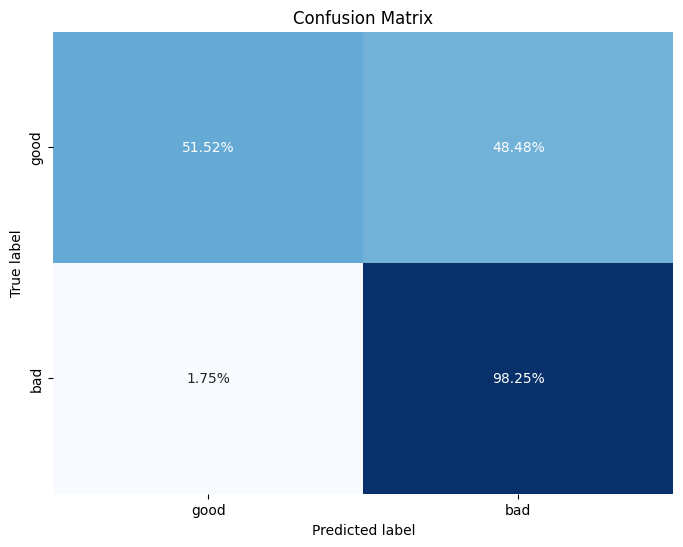

In [68]:
from util import provide_confusion_matrix

provide_confusion_matrix(y_te, y_pred)

F1: 0.830694275274056


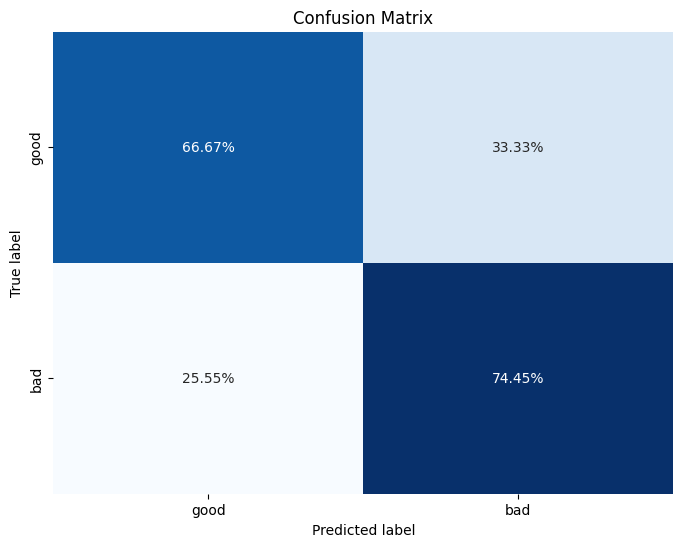

In [64]:
probs = clf.predict_proba(X_te)

# need to be 80% confident to predict bad
y_pred = np.array([1 if p[1] > 0.86 else 0 for p in probs])

# Create confusion matrix
cm = confusion_matrix(y_te, y_pred)
# f1
print('F1:', f1_score(y_te, y_pred))

provide_confusion_matrix(y_te, y_pred)

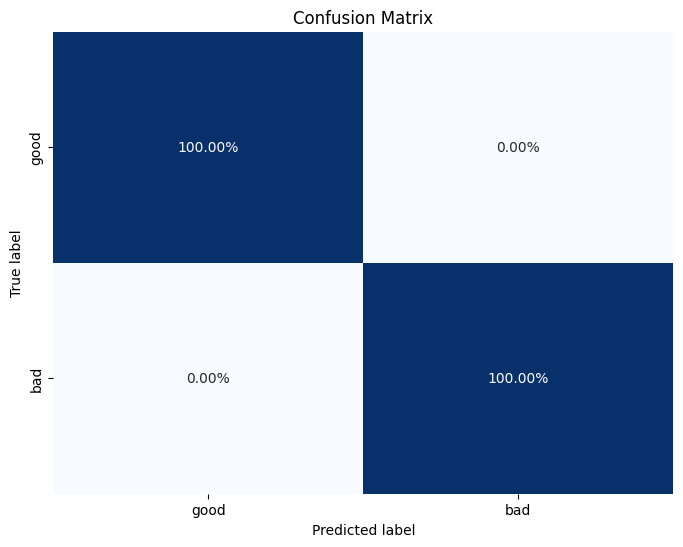

In [21]:
provide_confusion_matrix(y_tr, clf.predict(X_tr))

priv vectors, no stopwords:\
avg: 51/48; 2/98\
min: 42; 1.3\
max: 38; 2